# Titanic: Machine Learning from Disaster

This is my first Kaggle competition applying the knowledge I have acquired due to the last months / year.
This version is on purpose not shortened to display the learning process made during the write-up.

## Table of Content
* [Loading own functions](#first-bullet)
* [Data Overview](#second-bullet)
* [Data Pre-Processing: Feature Engineering](#third-bullet)
* [Data Pre-Processing: Handling Missing Values](#thirdand1-bullet)
* [Data Pre Processing: Transforming the variables into numericals](#fourth-bullet)
* [Data Pre Processing: Dropping uncessesary features](#fourthand1-bullet)
* [Exploratory Data Analysis](#fifth-bullet)
* [Machine Learning Models ](#sixth-bullet)
* [Cross Validation](#seventh-bullet)
* [Grid Search](#eight-bullet)


Thanks for Feature Engineering:
* https://www.kaggle.com/vbmokin/titanic-0-83253-comparison-20-popular-models
* https://www.kaggle.com/startupsci/titanic-data-science-solutions
* https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial#2.-Feature-Engineering

Thanks for Grid Search:
* https://www.kaggle.com/umarsajjad/top-3-titanic-survival-determination#6---Feature-Engineering

In [56]:
import pandas as pd
import numpy as np
import sklearn as skl
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

SEED = 42
#Pandas - Displaying more rorws and columns
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

## Loading own functions <a class="anchor" id="first-bullet"></a>

In [57]:
def my_df_summary(data):
    '''Own summary function'''
    try:
        dat = data.copy()
        Q1 = dat.quantile(0.25)
        Q3 = dat.quantile(0.75)
        IQR = Q3 - Q1        
    
        df = pd.DataFrame([dat.sum(), dat.min(), dat.max(), ((dat < (Q1 - 1.5 * IQR)) | (dat > (Q3 + 1.5 * IQR))).sum(), dat.mean(), dat.std(), dat.median(), dat.count(), dat.isna().sum(), dat.nunique(), dat.dtypes],
                     index=['Summe','Minimum', 'Maximum', 'Ausreißer', 'Mittelwert', 'Stand. Abw.', 'Median', 'Anzahl', '#NA', '#Uniques', 'dtypes'])        
        print('In total there are {} rows with {} variables in the dataset.'.format(len(data),(len(data.columns))))

        return df
    except:
        print('A summary of the dataset was not possible.')
        return data

In [58]:
def plot_num(df):
    try:

        '''Function for Plotting all numeric columns (histograms and boxplots) for df'''
        fig = plt.figure(figsize=(20,50))

        df_plot = df.select_dtypes('number')

        for i in range(len(df_plot.columns)):
            ax = int(i*2)+1
            ax1=fig.add_subplot(9,2,ax)
            df_plot.iloc[:,i].plot(kind='hist', bins=50,ax=ax1)
            plt.title(df_plot.columns[i])
            ax = ax+1
            ax2=fig.add_subplot(9,2,ax)
            df_plot.iloc[:,i].plot(kind='box', ax=ax2)
            plt.title(df_plot.columns[i])
        return plt.show()  
    except ValueError:
        pass  # do nothing!    

In [59]:
def df_norm(df,target_col,force_num=None,norm_target=True):
    '''Normalize dataframe df. Target column will be put at the end. force_num can be an additional column which is forced to be numeric. '''
    if force_num != None:
        df[force_num] = pd.to_numeric(df[force_num], errors='ignore')

    cats = df.select_dtypes('object')
    nums = df.select_dtypes('number')

    from sklearn.preprocessing import MinMaxScaler
    minmax = MinMaxScaler()
    num_tf = pd.DataFrame(minmax.fit_transform(nums))
    num_tf.columns=nums.columns
    if norm_target == False:
        num_tf.drop(target_col,axis=1,inplace=True)
        cats = cats.apply(LabelEncoder().fit_transform)
        cats = cats.reset_index(drop=True)
        df = pd.concat([cats, num_tf, df[target_col]],axis=1)
    else:
        cats = cats.apply(LabelEncoder().fit_transform)
        cats = cats.reset_index(drop=True)
        df = pd.concat([cats,num_tf],axis=1)
    return df

In [60]:
def fill_na_all(df):
    '''Fill all na for dataframe df. For numerics take mean, for categories take most frequent.'''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    cats = df.select_dtypes(exclude=numerics)
    nums = df.select_dtypes(include=numerics)
    
    for i in nums.columns:
        nums[i].fillna(nums[i].mean(),inplace=True)
    for n in cats.columns:
        cats[n].fillna(cats[n].mode()[0])
    cats = cats.reset_index(drop=True)
    nums = nums.reset_index(drop=True)
    df = pd.concat([cats,nums],axis=1)
    return df

In [61]:
# ignoring chained assignments error
pd.options.mode.chained_assignment = None  # default='warn'

In [62]:
#!kaggle competitions download -c titanic

In [63]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
df = pd.concat([train_data, test_data],axis=0,sort=False)

In [64]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Data Overview  <a class="anchor" id="second-bullet"></a>

In [65]:
my_df_summary(df)

In total there are 1309 rows with 12 variables in the dataset.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Summe,857395,342,3004,"Braund, Mr. Owen HarrisCumings, Mrs. John Brad...",malefemalefemalefemalemalemalemalemalefemalefe...,31255.7,653,504,A/5 21171PC 17599STON/O2. 31012821138033734503...,43550.5,NaN,NaN
Minimum,1,0,1,"Abbing, Mr. Anthony",female,0.17,0,0,110152,0,NaN,NaN
Maximum,1309,1,3,"van Melkebeke, Mr. Philemon",male,80,8,9,WE/P 5735,512.329,NaN,NaN
Ausreißer,0,0,0,0,0,9,57,307,0,171,0,0
Mittelwert,655,0.383838,2.29488,NaN,NaN,29.8811,0.498854,0.385027,NaN,33.2955,NaN,NaN
Stand. Abw.,378.02,0.486592,0.837836,NaN,NaN,14.4135,1.04166,0.86556,NaN,51.7587,NaN,NaN
Median,655,0,3,NaN,NaN,28,0,0,NaN,14.4542,NaN,NaN
Anzahl,1309,891,1309,1309,1309,1046,1309,1309,1309,1308,295,1307
#NA,0,418,0,0,0,263,0,0,0,1,1014,2
#Uniques,1309,2,3,1307,2,98,7,8,929,281,186,3


There are 891 people in the dataset with 342 of them have survived the incident.

In total the 12 different variables are:

|Variable|Definition|Key|
|:---|:---|:---|
|Passengerid| Unique ID for each passenger | |
|survival| 	Survival of Person| 	0 = No, 1 = Yes|
|pclass| 	Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd|
|Name| Passenger Name including title| |
|sex| 	Sex| |
|Age| 	Age in years | |
|sibsp| # of siblings / spouses aboard the Titanic | |
|parch|  of parents / children aboard the Titanic |	|
|ticket| 	Ticket number | 	|
|fare| 	Passenger fare 	|
|cabin| 	Cabin number |	
|embarked| 	Port of Embarkation| 	C = Cherbourg, Q = Queenstown, S = Southampton|

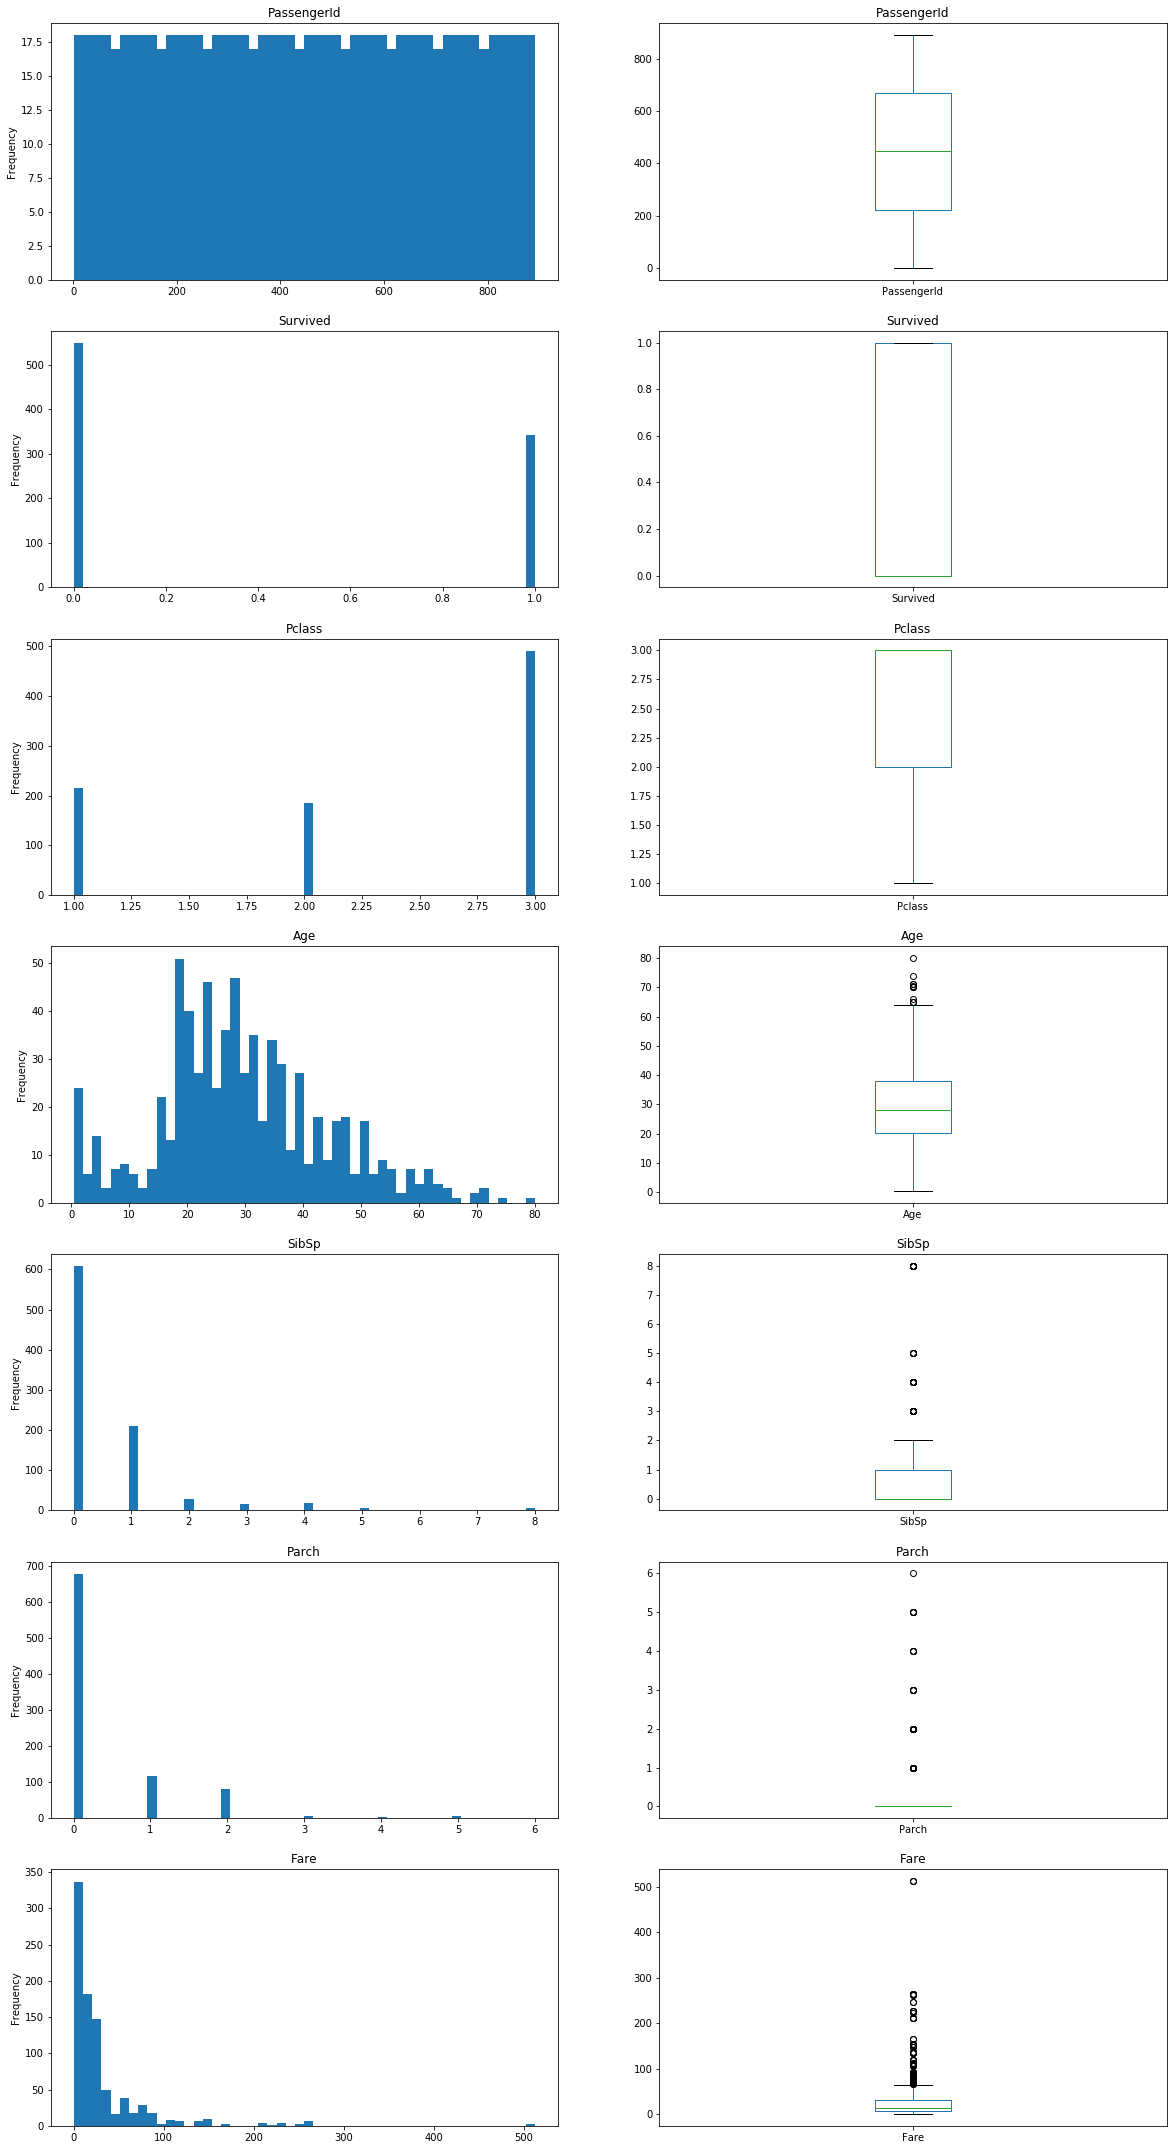

In [66]:
plot_num(train_data)

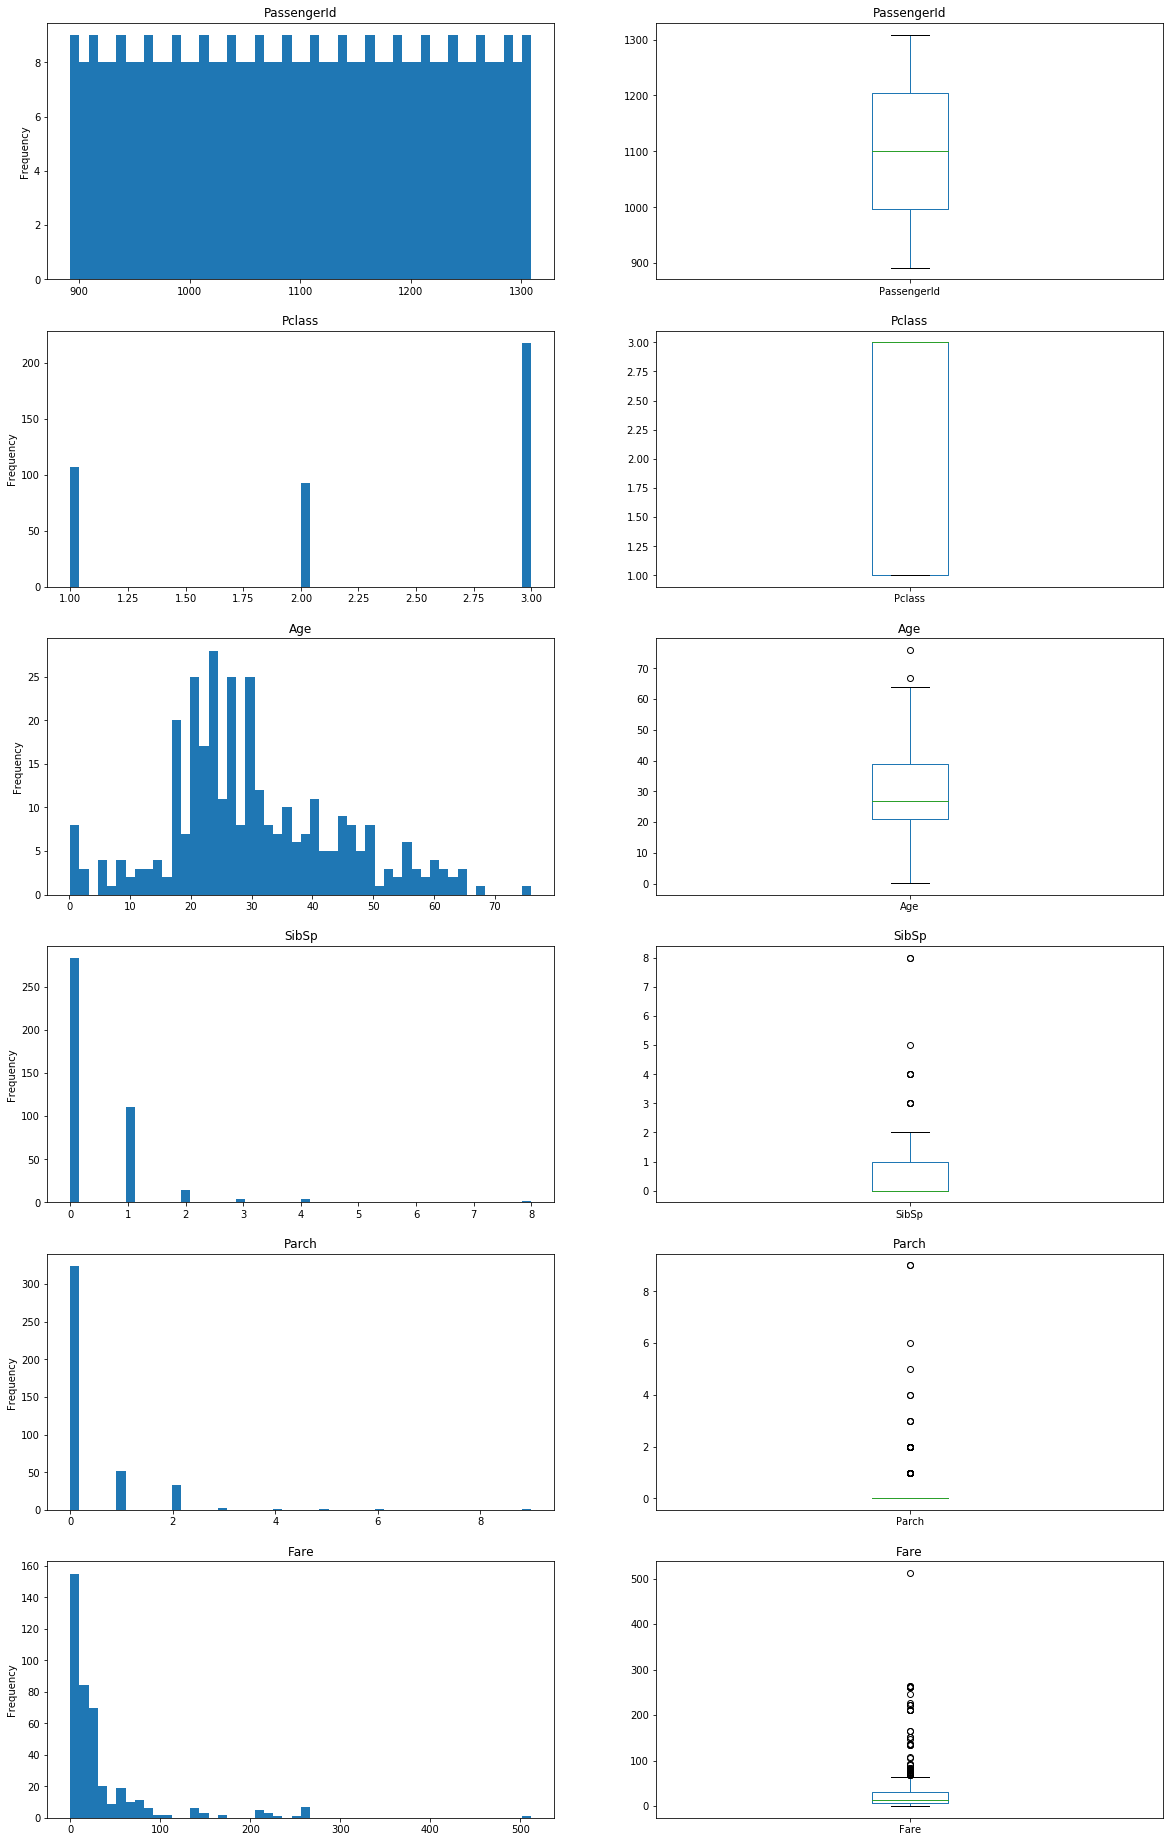

In [67]:
plot_num(test_data)

Between the two datasets there does not seem to be any obvious differences in distribution of the features.

We see that we have some outliers in Fare, SibSp and Parch. We need to handle them later.

## Data Pre-Processing: Feature Engineering <a class="anchor" id="third-bullet"></a>

### Title

At a first glance, it seems like the Name variable is unnecessary but let's see if we can extract additional information from it e.g. through extracting the title. 

In [68]:
name = df["Name"].copy()
name = name.str.split("[,.]", expand=True)
name.columns = ["LastName","Title","FirstName","Additional"]
name

,LastName,Title,FirstName,Additional
0,Braund,Mr,Owen Harris,None
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer),None
2,Heikkinen,Miss,Laina,None
3,Futrelle,Mrs,Jacques Heath (Lily May Peel),None
4,Allen,Mr,William Henry,None
...,...,...,...,...
413,Spector,Mr,Woolf,None
414,Oliva y Ocana,Dona,Fermina,None
415,Saether,Mr,Simon Sivertsen,None
416,Ware,Mr,Frederick,None


We seem to have one name with more than one , or . in it (i.e. column 3 is not NA)

In [69]:
name[name.iloc[:,3].isna()==False]

,LastName,Title,FirstName,Additional
513,Rothschild,Mrs,Martin (Elizabeth L,Barrett)


Since this is only ony case, we can ignore the additional column

In [70]:
name = name.iloc[:,0:3]

Let's see what and how many different titles we currently have.

In [71]:
name.iloc[:,1].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

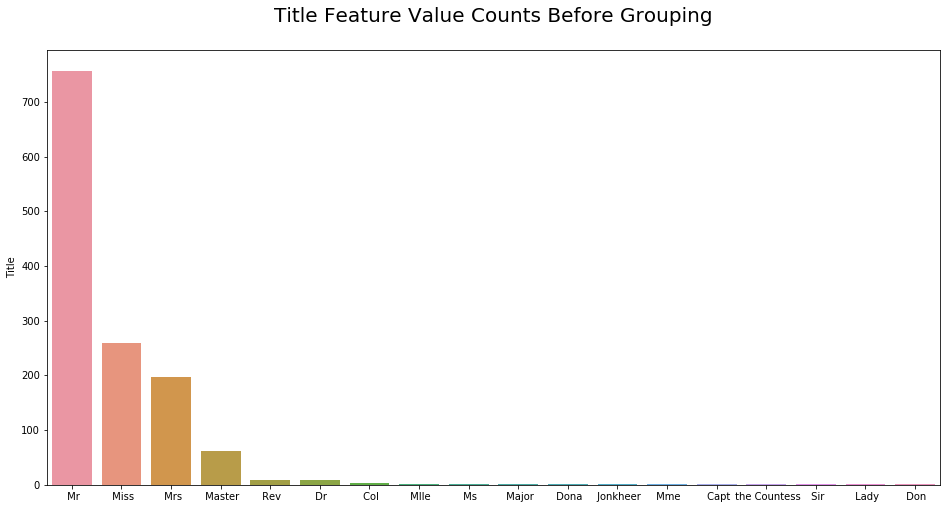

In [72]:
plt.figure(figsize=(16,8))
sns.barplot(x=name.iloc[:,1].value_counts().index,y=name.iloc[:,1].value_counts()).set_title('Title Feature Value Counts Before Grouping', size=20, y=1.05)
plt.show()

In [73]:
name.iloc[:,1].value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Mlle              2
 Ms                2
 Major             2
 Dona              1
 Jonkheer          1
 Mme               1
 Capt              1
 the Countess      1
 Sir               1
 Lady              1
 Don               1
Name: Title, dtype: int64

Besides the most common titles Mr, Miss and Mrs, there seem to be more rarely used titles (e.g. Dr, Don or Lady).

In [74]:
name["Title"] = name["Title"].str.strip()

In [75]:
name["Title"] = name["Title"].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
name["Title"].replace(['Mlle','Ms'], 'Miss',inplace=True)
name["Title"].replace('Mme', 'Mrs',inplace=True)
name["Title"].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

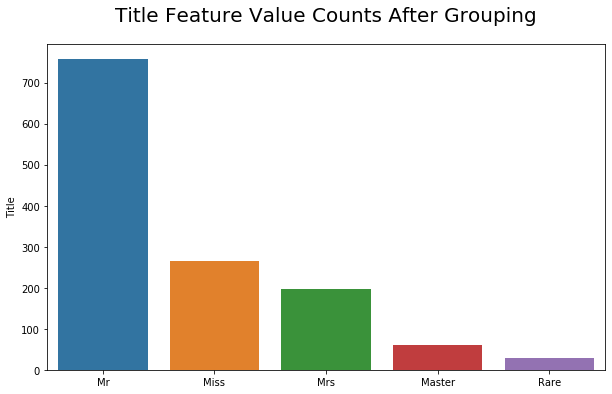

In [76]:
plt.figure(figsize=(10,6))
sns.barplot(x=name.iloc[:,1].value_counts().index,y=name.iloc[:,1].value_counts()).set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)
plt.show()

In [77]:
df = pd.concat([df,name["Title"]],axis=1, ignore_index=False)

In [78]:
df['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

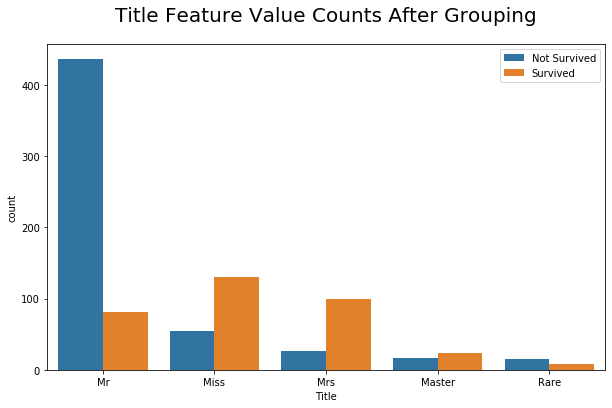

In [79]:
plt.figure(figsize=(10,6))
sns.countplot(x=df['Title'],
             hue=df["Survived"],
             order = df['Title'].value_counts().index).set_title(
                    'Title Feature Value Counts After Grouping', 
                    size=20, 
                    y=1.05)
plt.legend(loc='upper right', labels=['Not Survived', 'Survived'])
plt.show()

### FamilySize

From the two columns SibSp (Number of Siblings or Spouses on board) and Parch (number of Parents or Children on board) we can create a new variable representing the group size.

In [80]:
df["FamilySize"] = df["SibSp"]+df["Parch"]+1

In [81]:
df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Furthermore, Group Sizes are further grouped:

* Group Size with 1 are labeled as Alone
* Group Size with 2, 3 and 4 are labeled as Small
* Group Size with 5 and 6 are labeled as Medium
* Group Size with 7, 8 and 11 are labeled as Large


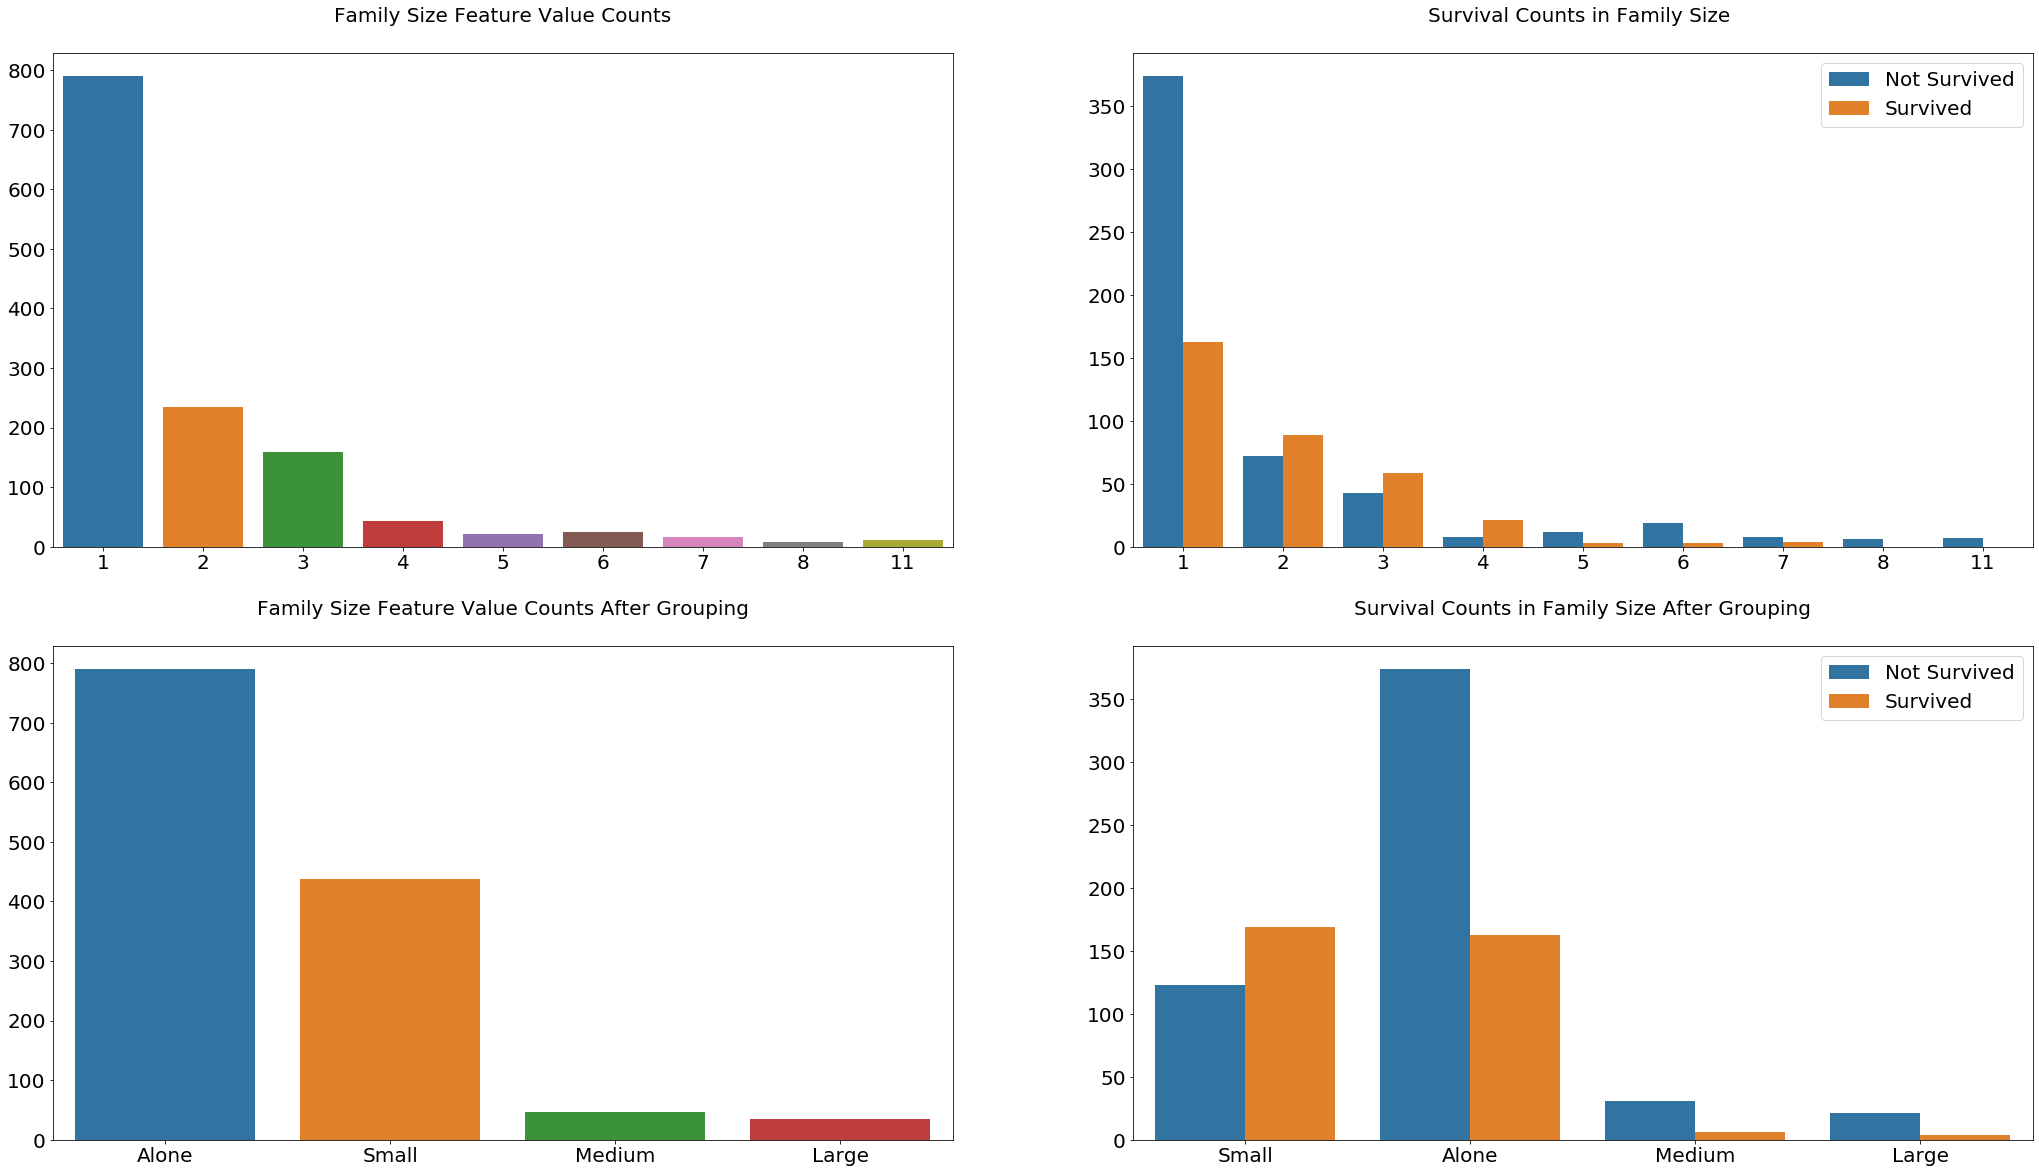

In [82]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df['FamilySize'].value_counts().index, y=df['FamilySize'].value_counts().values, ax=axs[0][0])
sns.countplot(x='FamilySize', hue='Survived', data=df, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df['FamilySizeGrouped'] = df['FamilySize'].map(family_map)

sns.barplot(x=df['FamilySizeGrouped'].value_counts().index, y=df['FamilySizeGrouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='FamilySizeGrouped', hue='Survived', data=df, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

### TicketFrequency (i.e. GroupSize)

Grouping tickets by their frequencies, reveals that many passengers travelled along with groups consisting of friends, nannies, maids, etc. They were not count as family, but used the same ticket.

In [83]:
df.groupby('Ticket')['Ticket'].transform('count')

0      1
1      2
2      1
3      2
4      1
      ..
413    1
414    3
415    1
416    1
417    3
Name: Ticket, Length: 1309, dtype: int64

In [84]:
df['TicketFrequency'] = df.groupby('Ticket')['Ticket'].transform('count')

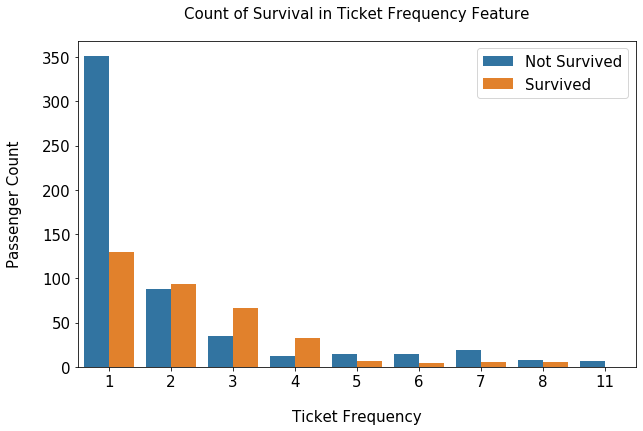

In [85]:
plt.figure(figsize=(10,6))
sns.countplot(x='TicketFrequency', hue='Survived', data=df)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

According to the graph , groups with 2,3 and 4 members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After 4 group members, survival rate decreases drastically. 

This pattern is very similar to FamilySize feature but there are minor differences. TicketFrequency values are not grouped like FamilySize because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

### HasCabin

From the Cabin number we can find out whether the person travelling had a cabin or not. 

In [86]:
df["HasCabin"]= ""
df["HasCabin"][df["Cabin"].isnull()==True]=0
df["HasCabin"][df["Cabin"].isnull()==False]=1

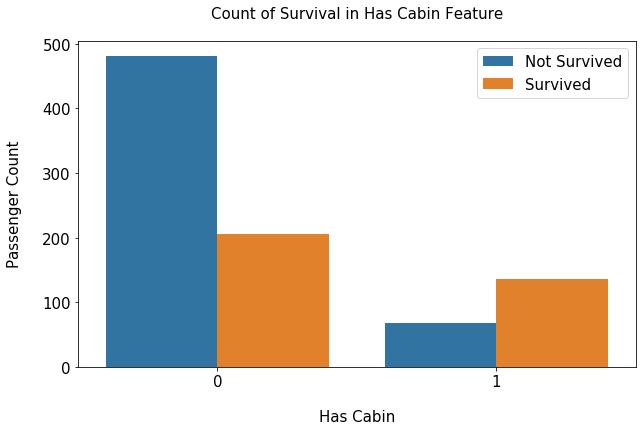

In [87]:
plt.figure(figsize=(10,6))
sns.countplot(x='HasCabin', hue='Survived', data=df)

plt.xlabel('Has Cabin', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Has Cabin'), size=15, y=1.05)

plt.show()

### IsWomanOrBoy

We have already taken a look at the different titles. However, we can take a closer look at the title "Master".   

Taking a look at the origin of the title Master [(source)](https://en.wikipedia.org/wiki/Master_(form_of_address)):_Master was retained as a form of address only for boys who had not yet entered society. By the late 19th century, etiquette dictated that men be addressed as Mister, and boys as Master._ 

As commonly known, in a ship tragedy, woman or children are rescued first. So, we can use this to create a new variable calld IsWomanOrBoy

In [88]:
df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))

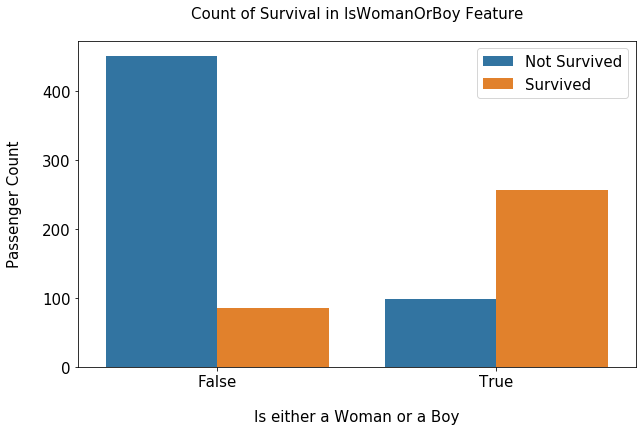

In [89]:
plt.figure(figsize=(10,6))
sns.countplot(x='IsWomanOrBoy', hue='Survived', data=df)

plt.xlabel('Is either a Woman or a Boy', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('IsWomanOrBoy'), size=15, y=1.05)

plt.show()

## Data Pre-Processing: Handling Missing Values <a class="anchor" id="thirdand1-bullet"></a>

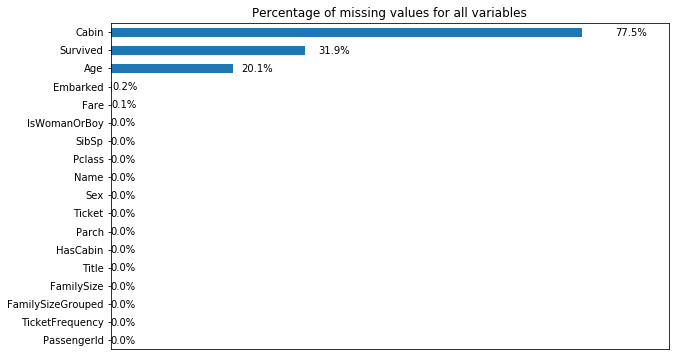

In [90]:
plt.figure(figsize=(10,6))
y = np.round(df.isna().sum().sort_values()/len(df)*100,1)
df.isna().sum().sort_values().plot(kind="barh")

for index, value in enumerate(y):
    plt.text(value*14, index - 0.2, '{:.1f}%'.format(float(value)))

plt.title('Percentage of missing values for all variables')
plt.xticks([])
plt.xlim(0,1200)
plt.show()

Another way of displaying missing values is the following:

Text(0.5, 1, 'Missing values heatmap')

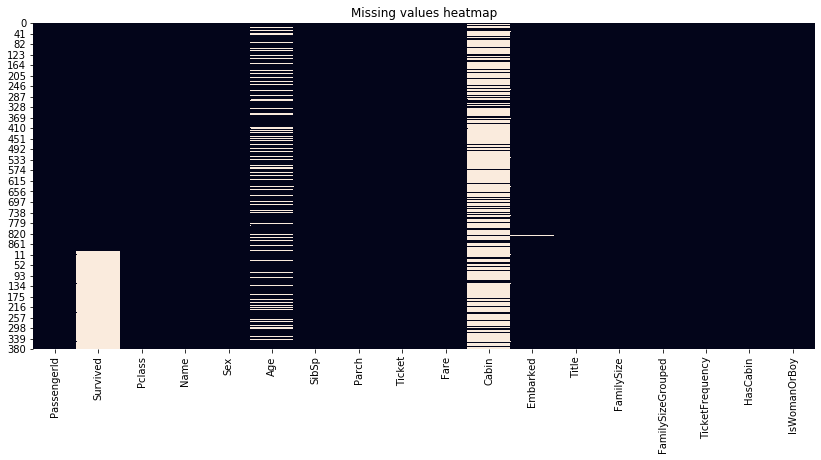

In [91]:
plt.figure(figsize=(14,6))
sns.heatmap(df.isnull(), cbar = False).set_title("Missing values heatmap")

We have missing values in four features:  
1. age: 177 - adding up to ~20% so we could try filling the NAs  
2. class: 687 - since almost 78% are missing data, we might want to drop this column. Also, we have already used it in the Feature Engineering Part where we created the variable HasCabin.  
3. embarked: 2 - adding up to less than 1% so we should fill the NAs
4. Fare: 1 - adding up to less than 1% so we should fill the NAs

### Embarked

Let's start with the embarked column.

In [92]:
df[df["Embarked"].isnull()==True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilySizeGrouped,TicketFrequency,HasCabin,IsWomanOrBoy
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,1,Alone,2,1,True
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,1,Alone,2,1,True


There are several way how to handle this problem. Either we could do some research, to see if there is any information about how to fill these two rows. Or we could use backward or forward fill. Finally, we could also use the most frequent place, where people embarked (mode).

In [93]:
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace = True)

In [94]:
df.Embarked.isnull().sum()

0

### Age

We saw, that we have 177 missing values in the age column. As a starting point, we could take a look at the mean age looking at different splits like Sex or Pclass (or even both).

In [95]:
df.groupby(["Sex"])["Age"].mean()

Sex
female    28.687088
male      30.585228
Name: Age, dtype: float64

In [96]:
df.groupby(["Pclass"])["Age"].mean()

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

In [97]:
df.groupby(["Sex","Pclass"])[["Age"]].median()

Age
Sex    Pclass      
female 1       36.0
       2       28.0
       3       22.0
male   1       42.0
       2       29.5
       3       25.0

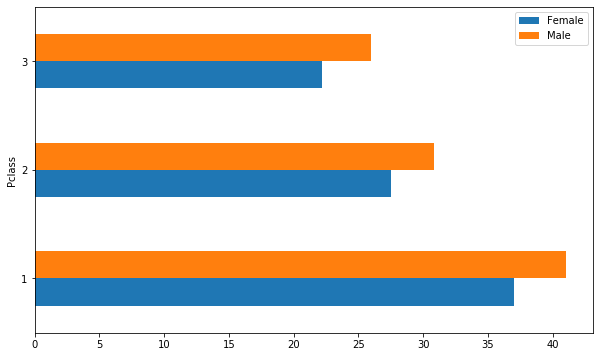

In [98]:
df.groupby(["Sex","Pclass"])[["Age"]].mean().unstack(0).plot(kind="barh",figsize=(10,6))
plt.legend(('Female', 'Male'))

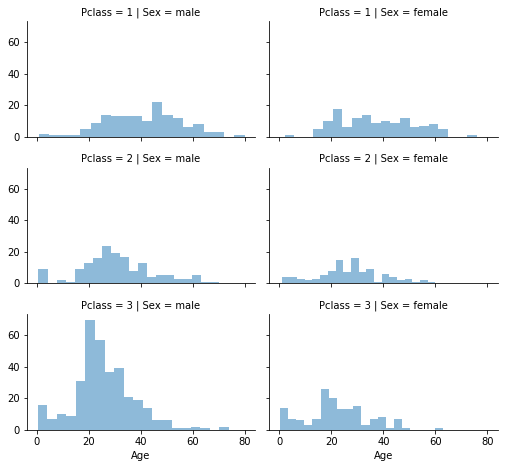

In [99]:
grid = sns.FacetGrid(df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()
plt.show()

We could use the latter to fill ages per sex and group.

In [100]:
ages = df.groupby(["Sex","Pclass"])[["Age"]].mean()
ages

Age
Sex    Pclass           
female 1       37.037594
       2       27.499223
       3       22.185329
male   1       41.029272
       2       30.815380
       3       25.962264

Let's use these group means for filling the NAs in the Age group.

In [101]:
df["Age"] = df.groupby(["Sex","Pclass"])[["Age"]].transform(
    lambda grp: grp.fillna(np.mean(grp))
)

We can furthermore, create age bands and determine their correlations with Survived

In [102]:
def age_to_group(age):
    if 0 < age < 12:
        # children
        return 0
    elif 12 <= age < 18:
        # teenie
        return 1
    elif 18 <= age < 50:
        # adult
        return 2
    elif age >= 50:
        # elderly people
        return 3

Let us now replace Age with ordinals based on these bands.

In [103]:
df['AgeGroup'] = df['Age'].apply(age_to_group)

### Cabin

As mentioned before, due to the high number of missing values, we could simply delete the cabin variable. 
However, we can also fill them with "NA", for now.

In [104]:
df["Cabin"].fillna("NA", inplace=True)

### Fare

Next up is Fare. Let's take a look at the mean here.

In [105]:
df["Fare"].mean()

33.2954792813456

In [106]:
df["Fare"].fillna(np.mean(df['Fare']), inplace=True)

Taking the Fare price, we can create a Fare band, dividing fare into four different groups:

In [107]:
df['FareBand'] = pd.qcut(df['Fare'], 4)


In [108]:
df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [109]:
df['Fare'][df['Fare'] <= 7.896] = 0
df['Fare'][(df['Fare'] > 7.896) & (df['Fare'] <= 14.454)] = 1
df['Fare'][(df['Fare'] > 14.454) & (df['Fare'] <=  31.275)]  = 2
df['Fare'][df['Fare'] >  31.275] = 3
df['Fare'] = df['Fare'].astype(int)

df = df.drop(['FareBand'], axis=1)

In [110]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FamilySizeGrouped,TicketFrequency,HasCabin,IsWomanOrBoy,AgeGroup
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0,NA,S,Mr,2,Small,1,0,False,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,3,C85,C,Mrs,2,Small,2,1,True,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,1,NA,S,Miss,1,Alone,1,0,True,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3,C123,S,Mrs,2,Small,2,1,True,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,1,NA,S,Mr,1,Alone,1,0,False,2


## Data Pre Processing: Transforming the variables into numericals <a class="anchor" id="fourth-bullet"></a>

Next, we need to change the type of the data into numericals for modelling.

In [111]:
df['HasCabin'] = df['HasCabin'].astype('int')

In [112]:
# Mapping the sex
df['Sex'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
# Mapping the title
title_mapping = {"Mr": 1, "Mrs": 2, "Miss": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)

df['IsWomanOrBoy'] = df['IsWomanOrBoy'].map( {True: 1, False: 0} )

Otherwise, we can also use the label encoder. 

LabelEncoder basically labels the classes from 0 to n. This process is necessary for models to learn from those features.

In [113]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
df['Embarked'] = le.fit_transform(df.Embarked)
#df['FamilySizeGrouped'] =le.fit_transform(df.FamilySizeGrouped)

For those categegories, which are ordinal variables **label encoding** works quite well as you can rank / order the outcomes of a feature (e.g. group of Age or Fare). For tree-based models (like decision trees and random forests), you can expect label encoding to work well with ordinal variables.

For most of our categorical variables (i.e. nominal variables), we cannot set a logical order (e.g. woman not better than men) therefore we use **One-Hot-Encoding**. One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., generally do not use it for variables taking more than 15 different values).

Therefore, we should convert the categorical features Pclass, Sex, Embarked, 	Title, GroupSizeGrouped, HasCabin, TravelsAlone and IsWomanOrBoy

In [114]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'FamilySizeGrouped', 'HasCabin', 'IsWomanOrBoy']
encoded_features = []

In [115]:
for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

In [119]:
df_final = df.copy()

In [120]:
df_final = pd.concat([df_final, *encoded_features], axis=1)

## Data Pre Processing: Dropping unnecessary features <a class="anchor" id="fourthand1-bullet"></a>

Before we start with the modeling, we will set PassengerId as index and drop all unnecessary object variables.  
Let us also drop Parch and SibSp features in favor of TravelsAlone and GroupSize, as well as the OneHotEncoded features

In [121]:
df_final.drop(cat_features,axis=1, inplace=True)

In [122]:
df_final.set_index("PassengerId", inplace=True)

In [123]:
df_final.drop(['Name','Ticket','Cabin','SibSp','Parch', 'Age', 'FamilySize'],axis=1, inplace=True)

In [124]:
df_final.rename(columns={'IsWomanOrBoy_2':'IsWomanOrBoy_True',
                         'IsWomanOrBoy_1':'IsWomanOrBoy_False',
                         'HasCabin_1': 'HasCabin_False',
                         'HasCabin_2':'HasCabin_True',
                         'FamilySizeGrouped_1':'FamilySizeGrouped_Alone',
                         'FamilySizeGrouped_4':'FamilySizeGrouped_Small',
                         'FamilySizeGrouped_3':'FamilySizeGrouped_Medium',
                         'FamilySizeGrouped_2':'FamilySizeGrouped_Large'
                        }, inplace=True)

In [131]:
df_final.head()

,Survived,Fare,TicketFrequency,AgeGroup,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Title_5,FamilySizeGrouped_Alone,FamilySizeGrouped_Large,FamilySizeGrouped_Medium,FamilySizeGrouped_Small,HasCabin_False,HasCabin_True,IsWomanOrBoy_False,IsWomanOrBoy_True
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.0,3,2,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1.0,1,1,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,3,2,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,0.0,1,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Exploratory Data Analysis <a class="anchor" id="fifth-bullet"></a>

So far, so good. Now that we have done some feature engineering and filled NAs let's take another look at the data.

In [132]:
my_df_summary(df_final)

In total there are 1309 rows with 25 variables in the dataset.


,Survived,Fare,TicketFrequency,AgeGroup,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Title_5,FamilySizeGrouped_Alone,FamilySizeGrouped_Large,FamilySizeGrouped_Medium,FamilySizeGrouped_Small,HasCabin_False,HasCabin_True,IsWomanOrBoy_False,IsWomanOrBoy_True
Summe,342,1958,2751,2483,323,277,709,466,843,270,123,916,757,198,264,61,29,790,35,47,437,1014,295,782,527
Minimum,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Maximum,1,3,11,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Ausreißer,0,0,62,264,323,277,0,0,0,270,123,0,0,198,264,61,29,0,35,47,0,295,295,0,0
Mittelwert,0.383838,1.4958,2.1016,1.89687,0.246753,0.211612,0.541635,0.355997,0.644003,0.206264,0.0939649,0.699771,0.578304,0.151261,0.201681,0.0466005,0.0221543,0.603514,0.026738,0.0359053,0.333843,0.774637,0.225363,0.597403,0.402597
Stand. Abw.,0.486592,1.12289,1.77983,0.632381,0.431287,0.408607,0.498454,0.478997,0.478997,0.404777,0.291891,0.458533,0.494019,0.35844,0.401408,0.210862,0.147242,0.489354,0.161378,0.186125,0.471765,0.417981,0.417981,0.490608,0.490608
Median,0,2,1,2,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0
Anzahl,891,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309,1309
#NA,418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
#Uniques,2,4,9,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


One way to look at relations in the data is to take a look at correlations.

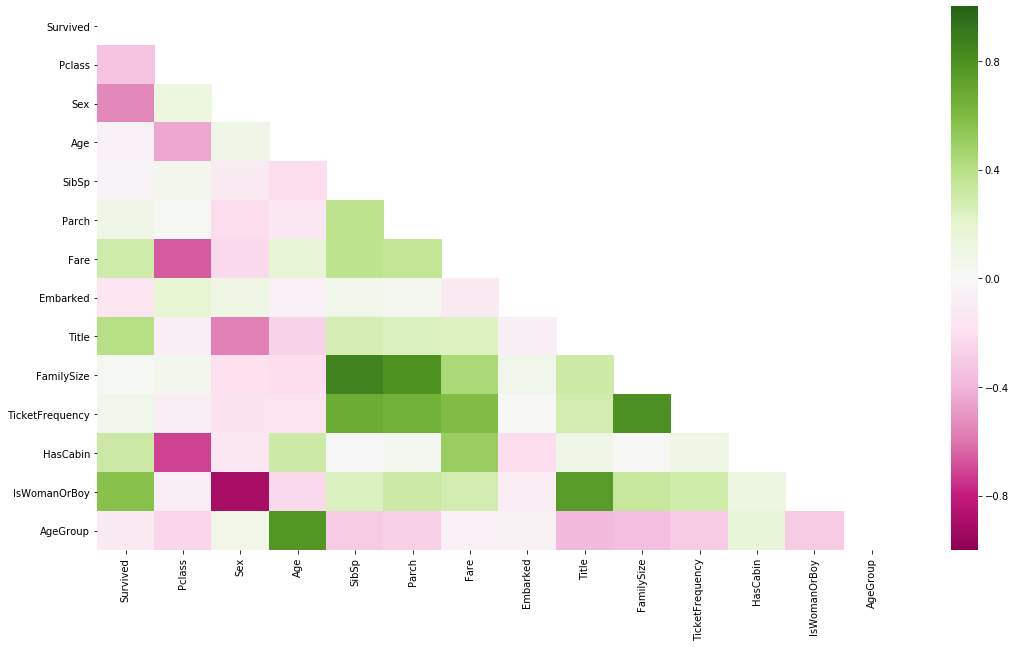

In [133]:
plt.figure(figsize=(18,10))
corr = df.iloc[:,1:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,mask=mask, vmin=-1,cmap='PiYG', annot=False);
plt.yticks(rotation=0)
plt.xticks(rotation=90)
#Nur notwendig, weil Grafik bei einer anderen Version von matplotlib (>3.3) sonst verzerrt. Bekannter Bug.
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

From here we can see some variables which are highly negative correlated:
1. HasCabin & Fare: People without a cabin pay a lower Fare than with a cabin

Besides, we have some positive correlations:
1. HasCabin & Pclass_1: People with a Cabin are usually travelling in Class 1
2. FamilySizeGrouped and Fare: The higher the Grouped Family Size (i.e. the larger the group) the higher the Fare


However, we have to ignore correlations between two object variables, e.g.:
* Title and Sex: There is no meaning of the correlation and obviously a woman with a title "Mrs" is in the womanorboy group

More interestingly, when looking at the correlation between survived and other features:

In [134]:
pd.DataFrame(df_final.iloc[:,1:].corr().iloc[0].sort_values(ascending=False))

,Fare
Fare,1.000000
Pclass_1,0.607560
TicketFrequency,0.591047
HasCabin_True,0.506170
FamilySizeGrouped_Small,0.449325
IsWomanOrBoy_True,0.282711
Title_2,0.273209
Sex_1,0.231632
Embarked_1,0.217211
FamilySizeGrouped_Large,0.171490


1. Survived & Fare: The higher the Fare, the higher the chance of survival
2. Survived & Pclass: The lower the class (1st class is lower than 2nd) the betther the chance of survival
3. Survived & HasCabin: People having a Cabin seem to have a higher probability of surviving
4. Survived & FamilySizeGrouped_Small: A small family group has a higher chance of survival than when traveling alone

By looking at different group means, we can further analyze our data:

In [135]:
df[["Pclass", 'Survived']].groupby(["Pclass"], as_index=False).agg(['mean', 'count', 'sum'])

Survived             
            mean count    sum
Pclass                       
1       0.629630   216  136.0
2       0.472826   184   87.0
3       0.242363   491  119.0

In [136]:
df[["FamilySizeGrouped", 'Survived']].groupby(["FamilySizeGrouped"], as_index=False).agg(['mean', 'count', 'sum'])

Survived             
                       mean count    sum
FamilySizeGrouped                       
Alone              0.303538   537  163.0
Large              0.160000    25    4.0
Medium             0.162162    37    6.0
Small              0.578767   292  169.0

## Machine Learning Models <a class="anchor" id="sixth-bullet"></a>

Starting with modeling, we need to divide our data into a training and a test dataset.  
We will then use the training data for our model to learn and the test dataset to see which model performs best.
  
We will use a split of 80% (training) to 20% (test dataset)

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
data_test = df_final[df_final["Survived"].isna()==True]
data_train = df_final[df_final["Survived"].isna()==False]

In [139]:
data_train.head()

,Survived,Fare,TicketFrequency,AgeGroup,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Title_5,FamilySizeGrouped_Alone,FamilySizeGrouped_Large,FamilySizeGrouped_Medium,FamilySizeGrouped_Small,HasCabin_False,HasCabin_True,IsWomanOrBoy_False,IsWomanOrBoy_True
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.0,3,2,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,1.0,1,1,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,3,2,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,0.0,1,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [140]:
i_split = 0.20
X_train, X_test, y_train, y_test = train_test_split(data_train.iloc[:,1:], data_train.iloc[:,0], test_size=i_split,
                                                    random_state=1234)

### Random Forest

We will now start with a random forest model:

Furthermore we also import some metrics to see e.g. the accuracy of our model.

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report

model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 
model.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=1,
                       warm_start=False)

In [142]:
predictions = model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.4s finished


In [143]:
df_conf_matrix = confusion_matrix(y_test,predictions)

In [144]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       109
         1.0       0.87      0.74      0.80        70

    accuracy                           0.85       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.86      0.85      0.85       179



Looking at the classification report, we predict with an accuracy of 85%, which is quite good.
We seem to have a higher precision with predicting the survivals (i.e. survived = 1) than the non-survivals (i.e. survived = 0). 

### Further models & Model comparison

How do other models perform in comparison to Random Forest?

In [145]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import time

In [146]:
models = [
    BernoulliNB(),
    GaussianNB(),
    KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs',max_iter=10000),
    SGDClassifier(),
    LinearSVC(max_iter=10000),
    SVC(gamma='auto',max_iter=-1),
    DecisionTreeClassifier(criterion='gini',max_depth=None),
    RandomForestClassifier(criterion='gini',n_estimators=1100,max_depth=5,min_samples_split=4,min_samples_leaf=5,max_features='auto',oob_score=True,random_state=SEED,n_jobs=-1,verbose=1),
    AdaBoostClassifier(),
    MLPClassifier(max_iter=2000)
]

In [147]:
comparison = []

for model in models:
    before_model = time.time()
    classifier_name = str(type(model).__name__)
    list_of_labels = sorted(list(set(y_train)))
    fit = model.fit(X_train, y_train)
    before_pred = time.time()
    predictions = fit.predict(X_test)

    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    cms = confusion_matrix(y_test,predictions)
    
    comparison.append([classifier_name, str(round(accuracy*100,2))+'%',str(round(before_pred-before_model,4))+'s',str(round(time.time()-before_pred,4))+'s'])
    
comparison = pd.DataFrame(comparison)
comparison.columns = ['Model','Accuracy','Modelling Time', 'Prediction Time']
comparison.set_index('Model')
comparison.sort_values("Accuracy", ascending=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.3s finished


,Model,Accuracy,Modelling Time,Prediction Time
6,SVC,85.47%,0.0469s,0.0156s
8,RandomForestClassifier,85.47%,5.7505s,0.4533s
3,LogisticRegression,84.36%,0.0625s,0.0156s
5,LinearSVC,84.36%,0.4375s,0.0158s
0,BernoulliNB,83.8%,0.0156s,0.0156s
7,DecisionTreeClassifier,83.8%,0.0s,0.0156s
1,GaussianNB,83.24%,0.0156s,0.0s
2,KNeighborsClassifier,83.24%,0.0156s,0.0312s
10,MLPClassifier,83.24%,6.0943s,0.0156s
9,AdaBoostClassifier,82.12%,0.2187s,0.0312s


SVC and Random Forest seem to be our best two models, performing better than 85%

Let's see how we perform when we submit the data, using our random forest  model:

### Random Forest - submission

In [174]:
#data_test.set_index('PassengerId',inplace=True)

In [175]:
model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 
fit = model.fit(data_train.iloc[:,1:],data_train.iloc[:,0])
predictions = fit.predict(data_test.iloc[:,1:])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.4s finished


In [176]:
data_test.reset_index(inplace=True)

In [177]:
submission = pd.DataFrame({
        "PassengerId": data_test["PassengerId"],
        "Survived": predictions
    })

In [152]:
submission = submission.astype('int64')
submission.to_csv('submissionRF.csv',index=False)

The submission reveals an accuracy of 79.425%. A little lower than expected. However, it might have two reasons:
1. we need to do cross validation to ensure we are picking a random model
2. we might be overfitting, using too many variables

Let's start with the first idea in short, but first, let's take a look at the importance of our features.

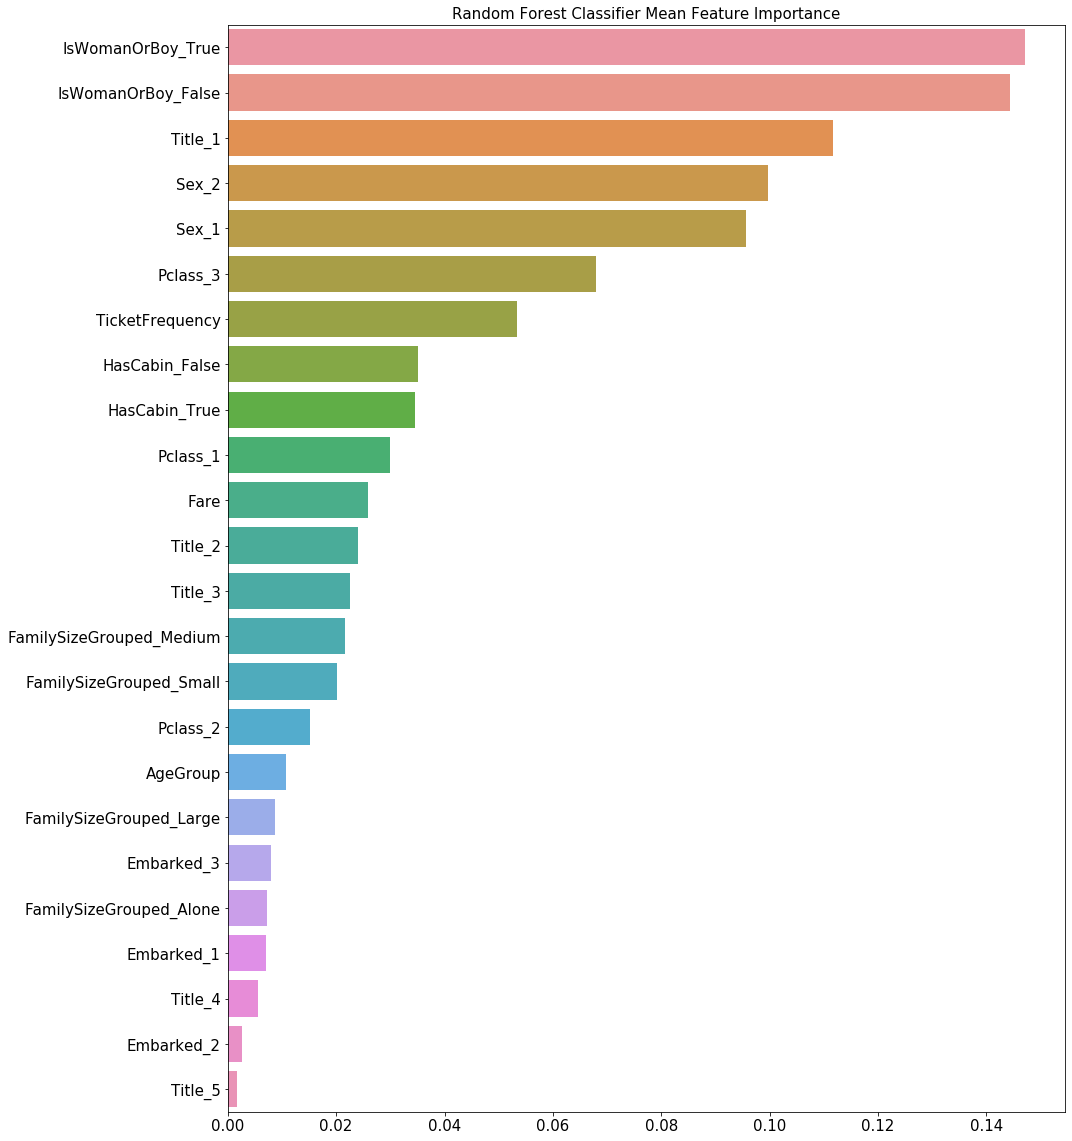

In [191]:
parameters = pd.Series(fit.feature_importances_, index=data_test.iloc[:,2:].columns).sort_values(ascending=False)
plt.figure(figsize=(15, 20))
sns.barplot(x=parameters, y=parameters.index)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance', size=15)

plt.show()

## Cross Validation <a class="anchor" id="seventh-bullet"></a>

In [153]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

my_pipeline = make_pipeline(SimpleImputer(), RandomForestClassifier(n_estimators=100))

For a full list of scoring metrics see this [link](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [154]:
from sklearn.metrics import accuracy_score
scores = cross_val_score(my_pipeline, data_train.iloc[:,1:], data_train.iloc[:,0], 
                         scoring='accuracy', 
                         cv=10)
print(scores)

[0.76666667 0.82222222 0.74157303 0.84269663 0.87640449 0.87640449
 0.87640449 0.78651685 0.87640449 0.85227273]


In [155]:
print('Accuracy %.02f' %(100*scores.mean()) +'%')

Accuracy 83.18%


In comparison to our previous accuracy of 85%, we now get a lower, more realistic accuracy of 83%.

Let's do the same thing again for all of our other models.

In [156]:
comparison = []

for model in models:
    before_model = time.time()
    classifier_name = str(type(model).__name__)
    list_of_labels = sorted(list(set(y_train)))
    before_pred = time.time()
    
    my_pipeline = make_pipeline(SimpleImputer(), model)
    scores = cross_val_score(my_pipeline, data_train.iloc[:,1:], data_train.iloc[:,0], scoring='accuracy', cv=10)

    
    comparison.append([classifier_name, str(round(scores.mean()*100,2))+'%',str(round(before_pred-before_model,4))+'s',str(round(time.time()-before_pred,4))+'s'])
    
comparison = pd.DataFrame(comparison)
comparison.columns = ['Model','Accuracy','Modelling Time', 'Prediction Time']
comparison.set_index('Model')
comparison.sort_values("Accuracy", ascending=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks   

,Model,Accuracy,Modelling Time,Prediction Time
8,RandomForestClassifier,83.5%,0.0s,48.7745s
3,LogisticRegression,83.28%,0.0s,0.7398s
6,SVC,83.27%,0.0s,0.625s
5,LinearSVC,82.83%,0.0s,4.4489s
7,DecisionTreeClassifier,82.39%,0.0s,0.1719s
2,KNeighborsClassifier,82.16%,0.0s,0.2656s
10,MLPClassifier,82.16%,0.0s,14.4099s
1,GaussianNB,81.71%,0.0s,0.1562s
9,AdaBoostClassifier,81.48%,0.0s,2.3283s
4,SGDClassifier,81.36%,0.0s,0.2813s


Now with 10-times cross validation, we see more realistic accuracy values for all models.
Still, the SVC and Random Forest are among the best models together with Logistic Regression and MLP achieving an accuracy of ~83%.

### Logistic Regression - submission
As Logistic Regression was performing second-best in our CV model comparison, let's hand in a submission with LogisticRegression

In [157]:
data_test.set_index('PassengerId',inplace=True)

In [158]:
model = LogisticRegression(solver='lbfgs',max_iter=10000)
fit = model.fit(data_train.iloc[:,1:],data_train.iloc[:,0])
predictions = fit.predict(data_test.iloc[:,1:])

In [159]:
data_test.reset_index(inplace=True)

In [160]:
submission = pd.DataFrame({
        "PassengerId": data_test["PassengerId"],
        "Survived": predictions
    })

In [161]:
submission = submission.astype('int64')
submission.to_csv('submissionLR.csv',index=False)

Logistic regression, however, only achieves 77.99% of accuracy.

In [162]:
coeff_df = pd.DataFrame(data_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
16,FamilySizeGrouped_Alone,1.349651
23,IsWomanOrBoy_True,0.974955
19,FamilySizeGrouped_Small,0.970146
14,Title_4,0.601029
3,Pclass_1,0.581144
21,HasCabin_True,0.387437
6,Sex_1,0.373926
12,Title_2,0.327537
8,Embarked_1,0.161565
4,Pclass_2,0.156553


We can use a Logistic Regression to validate our assumptions and decisions for feature creation. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

* FamilySizeGrouped_Alone is the highest positive coefficient, meaning that when belonging to this group (i.e. traveling alone) the probability of survival increases the most.
* IsWomanOrBoy is the second highest positive coefficient, meaning that when IsWomanOrBoy increases from 0 to 1 (i.e. is True), the probability of Survived = 1 increases the second most.
* Likely, HasCabin or Fare both have a positive influence once they increase (i.e. the person traveling has a cabin or has paid a higher Fare)
* On the other extreme, the higher the Class (i.e. the lower the Fare paid - see correlation above) the lower the chance of survival
* The Same counts for AgeGroup or when the person is not a woman or boy

### SVC - submission

Finally, let's also hand in our support vector machine model.

In [164]:
model = SVC(gamma='auto')
fit = model.fit(data_train.iloc[:,1:],data_train.iloc[:,0])

In [167]:
predictions = fit.predict(data_test.iloc[:,2:])

In [168]:
data_test.head()

,PassengerId,Survived,Fare,TicketFrequency,AgeGroup,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Embarked_1,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Title_5,FamilySizeGrouped_Alone,FamilySizeGrouped_Large,FamilySizeGrouped_Medium,FamilySizeGrouped_Small,HasCabin_False,HasCabin_True,IsWomanOrBoy_False,IsWomanOrBoy_True
0,892,NaN,0,1,2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,893,NaN,0,1,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,894,NaN,1,1,3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,895,NaN,1,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,896,NaN,1,2,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [169]:
submission = pd.DataFrame({
        "PassengerId": data_test["PassengerId"],
        "Survived": predictions
    })

In [170]:
submission = submission.astype('int64')

In [171]:
submission.to_csv('submissionSVC.csv',index=False)

Finally, the SVC model reaches an accuracy of 79.425%.

## Grid Search <a class="anchor" id="eight-bullet"></a>

We can finally improve our best model (RF) through grid search.

In [220]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

k_fold = StratifiedKFold(n_splits=5)
RF_classifier = RandomForestClassifier()


## Search grid for optimal parameters
RF_paramgrid = {"max_depth": [None],
                  "max_features": [1, 2 ,3, 4, 5, 10, 'auto'],
                  "min_samples_split": [2 , 5,  10],
                  "min_samples_leaf": [2, 5, 10],
                  "bootstrap": [True],
                  "n_estimators" :[100,200,300,400,500,1000,1100,1200,1300,1400,1500],
                  "criterion": ["gini"],
                  "oob_score": [True, False]
                   }


RF_classifiergrid = GridSearchCV(RF_classifier, param_grid = RF_paramgrid, cv=k_fold, scoring="accuracy", n_jobs= -1, verbose=1)

RF_classifiergrid.fit(X_train,y_train)

RFC_optimum = RF_classifiergrid.best_estimator_

# Best Accuracy Score
RF_classifiergrid.best_score_

Fitting 5 folds for each of 1386 candidates, totalling 6930 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 65.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 82.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 99.9min
[Parallel(n_jobs=-1)]: Done 6930 out of 6930 | elapsed: 112.8min finished


0.8356741573033708

In [221]:
RFC_optimum

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [224]:
model_rffinal=RandomForestClassifier(
                                    n_estimators=500,
                                    criterion='gini',
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=5,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=4,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    bootstrap=True,
                                    oob_score=True,
                                    n_jobs=None,
                                    random_state=SEED,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight=None
                                )

In [202]:
model_rffinal = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [225]:
fit = model_rffinal.fit(data_train.iloc[:,1:],data_train.iloc[:,0])

In [226]:
predictions = fit.predict(data_test.iloc[:,2:])

In [227]:
submission = pd.DataFrame({
        "PassengerId": data_test["PassengerId"],
        "Survived": predictions
    })
submission = submission.astype('int64')

In [228]:
submission.to_csv('submissionrfgrid.csv',index=False)

Unfortunately, after the grid search, the handed in model  reaches 80.382% of accuracy. This is so far our best model and a slight improvement in comparison to our 79.425% we achieved earlier. Currently this is ranked among the top 8% in kaggle titanic competition.